In [4]:
import rasterio
import rioxarray
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import pdb
import os
import dask
import rioxarray
import numpy as np
import pandas as pd

import warnings
from itertools import combinations
from dask.diagnostics import ProgressBar

In [3]:
import requests
import zipfile
import os

url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/composite_data/burned_area_extent_shapefile/mtbs_perimeter_data.zip'
filename = url.split("/")[-1]
directory = '/lfs/turing3/0/kaif/data/geometry'

# !mkdir "/content/drive/MyDrive/burned_area/mtbs_perims_DD"
os.makedirs(directory, exist_ok=True)

# Download the zip file
response = requests.get(url)
filepath = os.path.join(directory, filename)
with open(filepath, 'wb') as f:
    f.write(response.content)

# Unzip the file
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(directory)

# Remove the zip file if you want
os.remove(filepath)

In [5]:
root_dir = Path("/lfs/turing3/0/kaif/data/processed")
mask_root_dir = root_dir / "masks"
pre_root_dir = root_dir / "pre-fire-images"
post_root_dir = root_dir / "post-fire-images"

regions = [Path(f).stem for f in os.listdir(mask_root_dir)]

files_mask = {f: mask_root_dir / f'{f}.npy' for f in regions}
files_pre = {f: pre_root_dir / f'{f}.tif' for f in regions}
files_post = {f: post_root_dir / f'{f}.tif' for f in regions}
len(files_mask), len(files_pre), len(files_post), len(regions)

(1590, 1590, 1590, 1590)

In [ ]:
for region in regions:
    with rasterio.open(files_post[region]) as src:
        post_data = src.read()

In [19]:
region = regions[1]

with rasterio.open(files_post[region]) as src:
    data = src.read()
    transform = src.transform
    meta = src.tags()

mask = np.load(files_mask[region])

In [35]:
data[4].max()

24499.0

In [24]:
type(data)

numpy.ndarray

In [5]:
root_dir = Path("/lfs/turing3/0/kaif/data/processed")
pre_root_dir = root_dir / "pre-fire-images"
post_root_dir = root_dir / "post-fire-images"

files_pre = set(os.listdir(pre_root_dir))
files_post = set(os.listdir(post_root_dir))

files_pre = {Path(f).stem: pre_root_dir / f for f in files_pre}
files_post = {Path(f).stem: post_root_dir / f for f in files_post}

shared_files = list(files_pre.keys() & files_post.keys())

len(shared_files)

1592

In [22]:
# Open the MTBS data, this is the same data you get from the MTBS webpage
mtbs = gpd.read_file('/lfs/turing3/0/kaif/data/geometry')
wildfires_ca = mtbs[(mtbs.Event_ID.str.contains("CA") & (mtbs.Incid_Type == "Wildfire"))]
wildfires_ca = wildfires_ca.to_crs("EPSG:4326")
wildfires_ca.head(10)

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
23,CA3607412018819840329,NaN,FK 1817,Wildfire,4557,MTBS,Initial (SS),1462,36.074,-120.188,...,NaN,-9999,-9999,9999,9999,-65,-280,-9999,Single scene assessment,"POLYGON ((-120.18164 36.05393, -120.18211 36.0..."
24,CA3561111844619840526,NaN,WOODROW,Wildfire,4558,MTBS,Initial (SS),1118,35.611,-118.446,...,NaN,-9999,-9999,9999,9999,-25,-145,-225,NaN,"POLYGON ((-118.43784 35.60767, -118.43830 35.6..."
25,CA3800412064719840624,NaN,SALT SPRING,Wildfire,4560,MTBS,Initial (SS),4837,38.004,-120.647,...,NaN,-9999,-9999,9999,9999,50,-250,-9999,NaN,"POLYGON ((-120.66427 38.00380, -120.66919 38.0..."
26,CA3688312115819840705,NaN,PACHECO 2,Wildfire,4561,MTBS,Initial (SS),1231,36.883,-121.158,...,NaN,-9999,-9999,9999,9999,60,-250,-9999,NaN,"POLYGON ((-121.17580 36.88319, -121.17507 36.8..."
27,CA3557911838819840707,NaN,BODFISH,Wildfire,4562,MTBS,Extended,23189,35.579,-118.388,...,NaN,-25,-9999,-970,-150,50,151,300,Hard to tell burned area on NE corner.,"POLYGON ((-118.37548 35.61950, -118.37149 35.6..."
28,CA3640611884819840829,NaN,BAR-O,Wildfire,4564,MTBS,Extended,2987,36.406,-118.848,...,NaN,35,-9999,-970,-150,100,277,500,Edited Ca. Dept. Forestry perimeter,"POLYGON ((-118.83145 36.40752, -118.82959 36.4..."
29,CA3470111707519840512,NaN,STODDARD 2,Wildfire,4565,MTBS,Initial (SS),2458,34.701,-117.075,...,NaN,-9999,-9999,9999,9999,-50,-190,-9999,NaN,"POLYGON ((-117.06736 34.70991, -117.06670 34.7..."
31,CA4007812006619840705,NaN,TURTLE,Wildfire,4568,MTBS,Initial,3979,40.078,-120.066,...,NaN,-20,-9999,-970,-150,25,260,9999,NaN,"POLYGON ((-120.07087 40.10227, -120.06934 40.1..."
32,CA4068311999419840706,NaN,TWIN,Wildfire,4569,MTBS,Initial,21476,40.691,-120.022,...,NaN,8,37,-970,-150,75,133,250,"Fire was reproduced, high severity of original...","MULTIPOLYGON (((-119.96595 40.67202, -119.9657..."
33,CA4126012012019840809,NaN,EAGLE,Wildfire,4570,MTBS,Extended,1734,41.260,-120.120,...,NaN,38,-9999,-970,-150,90,247,450,NaN,"POLYGON ((-120.11093 41.25649, -120.11151 41.2..."


In [20]:
import rasterio
from rasterio.features import rasterize

def compute_mask(geometry, ds):
  # Convert selected_event to shape, value format
  shapes = [(geom, 1) for geom in geometry]

  # Get the transforms
  transform = ds.rio.transform()

  x, y = len(ds.coords['y']), len(ds.coords['x'])

  # Rasterize the geometry using rasterio.features.rasterize
  mask = rasterize(shapes=shapes, transform=transform, out_shape=(x, y))

  return mask

In [8]:
region = regions[0]

ds = (
    xr.open_dataset(files_post[region])
    .to_array() # transform to an array rather than the xr.Dataset
    .squeeze()  # just like in numpy, remove all singletons
)
ds.rio.set_crs(4326)
ds

<xarray.DataArray (band: 6, y: 118, x: 183)>
array([[[10549., 10696., 10789., ..., 11384., 11348., 11721.],
        [10765., 10563., 10422., ..., 11286., 11467., 11760.],
        [11053., 11065., 10951., ..., 11543., 11556., 11665.],
        ...,
        [11690., 11804., 11709., ..., 12243., 12363., 12612.],
        [11641., 11604., 11084., ..., 11400., 11597., 12118.],
        [11935., 11997., 11508., ..., 11423., 11459., 11156.]],

       [[12376., 12433., 12639., ..., 13275., 13522., 14188.],
        [12515., 12456., 11999., ..., 13262., 13666., 14237.],
        [13113., 13156., 12988., ..., 13458., 13695., 14275.],
        ...,
        [14240., 14531., 14335., ..., 15038., 15129., 15111.],
        [14281., 14101., 13389., ..., 13966., 14186., 14826.],
        [14434., 14598., 14047., ..., 13880., 13888., 13562.]],

       [[14024., 14188., 13984., ..., 14884., 15177., 16103.],
        [14199., 14005., 13657., ..., 14951., 15372., 15909.],
        [14718., 14630., 14413., ..., 15296., 15439., 16063.],
        ...,
...
        ...,
        [19692., 19925., 19718., ..., 20226., 19865., 20481.],
        [19697., 19609., 18568., ..., 18735., 19092., 20094.],
        [19716., 19877., 19065., ..., 18678., 18801., 18256.]],

       [[19028., 19203., 19036., ..., 22054., 21904., 22421.],
        [19778., 19302., 18258., ..., 21778., 22065., 22256.],
        [20525., 20348., 19502., ..., 21974., 22019., 22329.],
        ...,
        [21635., 22429., 22290., ..., 24349., 24341., 25007.],
        [21036., 21746., 21524., ..., 22400., 23003., 24529.],
        [21861., 22024., 21967., ..., 22386., 22653., 22191.]],

       [[ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
        [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
        [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
        ...,
        [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
        [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
        [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.]]])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6
  * x            (x) float64 -119.5 -119.5 -119.5 ... -119.5 -119.5 -119.5
  * y            (y) float64 35.24 35.24 35.24 35.24 ... 35.21 35.21 35.21 35.21
    spatial_ref  int64 ...
    variable     <U9 'band_data'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


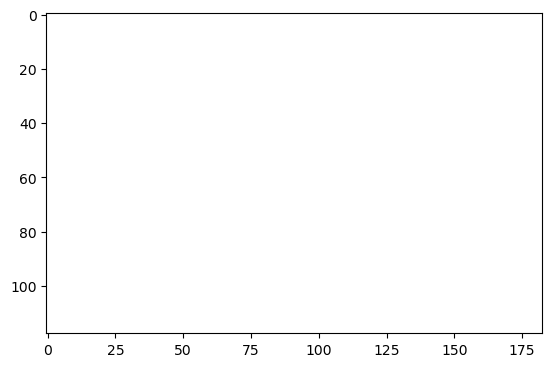

In [17]:
plt.imshow(ds.sel(band=[3, 2, 1]).transpose('y', 'x', 'band'))

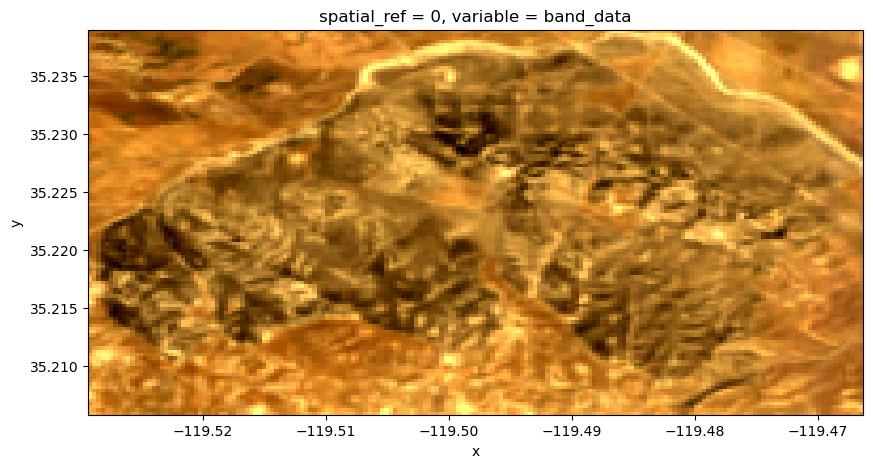

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ds.sel(band=[3, 2, 1]).plot.imshow(robust=True, ax=ax)

# Plot the boundary of the polygon, not the whole polygon
# len(wildfires_ca[wildfires_ca.Event_ID == region])#.geometry#.boundary#.plot(ax=ax)

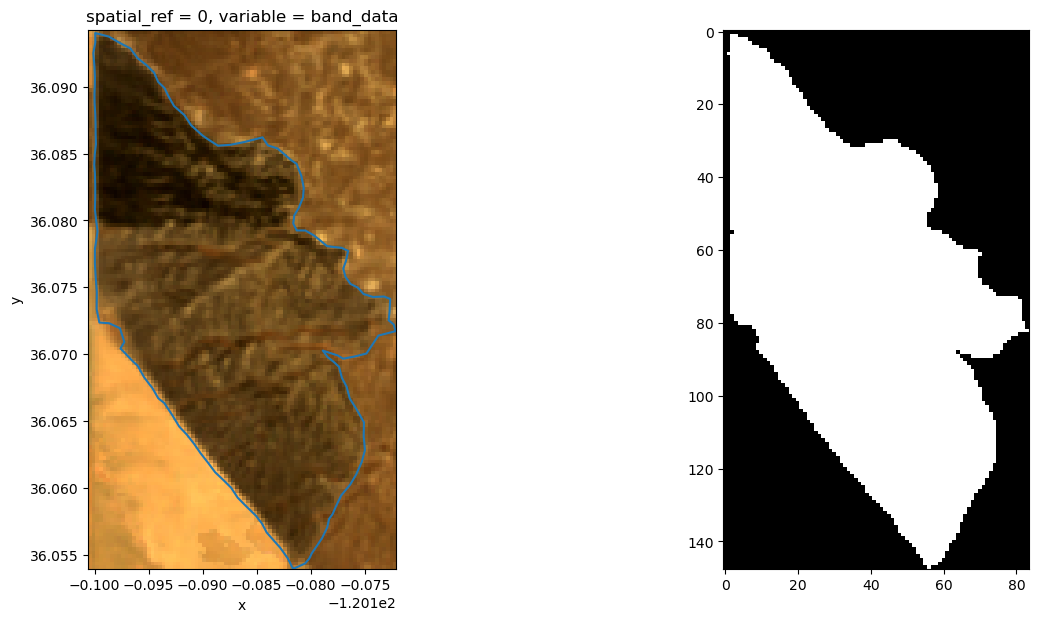

In [12]:
# Display the original and the binary mask
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

selected_event = wildfires_ca[wildfires_ca.Event_ID == region]

# Rasterize the geometry using rasterio.features.rasterize
mask = compute_mask(selected_event.geometry, ds)

# Original Image
ds.sel(band=[3, 2, 1]).plot.imshow(robust=True, ax=axs[0])

# Plot the boundary of the polygon, not the whole polygon
wildfires_ca[wildfires_ca.Event_ID == region].geometry.boundary.plot(ax=axs[0])
# mask.plot(ax=axs[0])

# Mask
axs[1].imshow(mask, cmap='gray')

In [35]:
save_dir = Path("/lfs/turing3/0/kaif/data/processed") / "masks"
os.makedirs(save_dir, exist_ok=True)
from tqdm import tqdm

for region in tqdm(shared_files):
    ds = (
        xr.open_dataset(files_post[region])
        .to_array()
        .squeeze()
    )
    ds.rio.set_crs(4326)
    selected_event = wildfires_ca[wildfires_ca.Event_ID == region]

    if len(selected_event) == 0:
        continue
   
    mask = compute_mask(selected_event.geometry, ds)
   
    np.save(os.path.join(save_dir, f"{region}.npy"), mask)

100%|███████████████████████████████████████| 1592/1592 [00:43<00:00, 36.48it/s]


In [9]:
pre_scaled_root_dir = root_dir / "pre-scaled-fire-images"
files_pre_scaled = {f: pre_scaled_root_dir / f'{f}.tif' for f in regions}

files_pre_scaled[shared_files[0]]

PosixPath('/lfs/turing3/0/kaif/data/processed/pre-scaled-fire-images/CA3855111951320070601.tif')

In [13]:
# pres_data = pre_data.interp_like(post_data, method="linear", kwargs={"fill_value": "extrapolate"})
from tqdm import tqdm

for region in tqdm(regions):
    ds_post = (
        xr.open_dataset(files_post[region])
        .to_array()
        .squeeze()
    )
    ds_post.rio.set_crs(4326)

    ds_pre = (
        xr.open_dataset(files_pre[region])
        .to_array()
        .squeeze()
    )
    ds_pre.rio.set_crs(4326)

    ds_pre = ds_pre.interp_like(ds_post, method="linear", kwargs={"fill_value": "extrapolate"})

    ds_pre.rio.to_raster(files_pre_scaled[region])

    ds_pre.compute()


100%|█████████████████████████████████████████████████| 1590/1590 [02:32<00:00, 10.42it/s]
